In [81]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median

MGGG used script check_shapefile_connectivity.py to fix topology errors in WI wards
https://github.com/gerrymandr/Preprocessing

**Just realized the code is deprecated, https://github.com/mggg/maup has new code and looks like it recommends using resolve_overlaps its place)**

**Load data**

Retrieve demographic data from Census API

To see the full list of census variables, look here: https://api.census.gov/data/2010/dec/sf1/variables.html


In [82]:
# Code chunk by Melisande Teng - VRDI 2019
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",  # these follow from above, so TOTPOP = P005001
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN",
    "NH_ASIAN",
    "NH_NHPI",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

import requests

def counties(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes


def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    """Inputs: state fips code, county fips code, list of variables and corresponding keys. 
    Process: formats the query to call the Census API. 
    Outputs: data for the county in a pandas dataframe. """
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    """Input: state_fips
    Process: Retrieve a list of county fips codes in the state. 
        The Census API only lets you query one county at a time, so you first need the full list. 
        Then call block_data_for_county() to retrieve the data at the county level. 
    Outputs: block-level data for the state fips for the list of variables defined above. 
    """
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [83]:
# Retrieve the block level data for the state
wi = block_data_for_state('55')
wi = wi.rename(columns={"geoid": "GEOID"})
wi.to_csv('wi_census_2010_blocks.csv')

In [84]:
# blocks = pd.read_csv("./raw-from-source/demographic_data/nhgis_ds172_2010_block.csv") #census data we queried above

# Block shapefile also retrieved separately from the census API 
block_shp = gp.read_file("./raw-from-source/WI_blk-level_shapefile/tl_2011_55_tabblock.shp")
# Precinct shapefile retrieved from mggg-states github
precincts = gp.read_file("./raw-from-source/2018-2012_Election_Data_with_2011_Wards-shp/2018-2012_Election_Data_with_2011_Wards.shp")


**Set shapefile projections**

Confirm the projection of the precinct shapefile, as documented here: https://github.com/mggg-states/WI-shapefiles

CRS = coordinate reference system

The WI shapefile  uses a NAD83 UTM zone 16 N (or EPSG:26916) projection

In [85]:
precincts.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
proj = precincts.crs

Project the block shapefile and precincts to NAD83, saved above


In [87]:
precincts = precincts.to_crs(proj)
block_shp = block_shp.to_crs(proj)

**Join block-level deomographic data with block-level shapefile**

In [88]:
block_shp.head(2)

,STATEFP,COUNTYFP,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,SUFFIX1CE,GEOID,NAME,MTFCC,UR10,UACE10,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,55,001,55,001,950700,2107,None,550019507002107,Block 2107,G5040,None,None,S,0,90921,+43.6628042,-089.6054812,"POLYGON ((-9975027.118 5413331.980, -9975028.6..."
1,55,001,55,001,950700,2050,None,550019507002050,Block 2050,G5040,None,None,S,3964383,8039,+43.7038060,-089.6211437,"POLYGON ((-9975220.811 5418062.810, -9975875.2..."


Join the block shapefile to the census demographic data on the GEOID


In [89]:
blk_joined = pd.merge(block_shp, wi , on='GEOID', how='left', indicator=True)

Check total population - join is good!

In [90]:
blk_joined.TOTPOP.sum()

5683569.0

In [91]:
blk_joined[['GEOID','geometry','TOTPOP','NH_WHITE','VAP']].head(10)

,GEOID,geometry,TOTPOP,NH_WHITE,VAP
0,550019507002107,"POLYGON ((-9975027.118 5413331.980, -9975028.6...",0.0,0.0,0.0
1,550019507002050,"POLYGON ((-9975220.811 5418062.810, -9975875.2...",22.0,22.0,18.0
2,550019507002077,"POLYGON ((-9978639.875 5419230.809, -9977371.0...",17.0,15.0,12.0
3,550019507002070,"POLYGON ((-9984178.351 5416906.206, -9984175.3...",0.0,0.0,0.0
4,550019507002091,"POLYGON ((-9978944.559 5414567.405, -9978946.1...",18.0,18.0,14.0
5,550019507002088,"POLYGON ((-9980943.635 5411449.009, -9981313.6...",8.0,8.0,7.0
6,550019507002049,"POLYGON ((-9975817.146 5423150.201, -9976330.5...",3.0,3.0,3.0
7,550019507002058,"POLYGON ((-9974694.157 5421708.938, -9974694.7...",0.0,0.0,0.0
8,550019507002074,"POLYGON ((-9980124.877 5416622.652, -9980119.8...",0.0,0.0,0.0
9,550019502011060,"POLYGON ((-10013822.363 5463188.915, -10013821...",0.0,0.0,0.0


Make sure the map looks right!

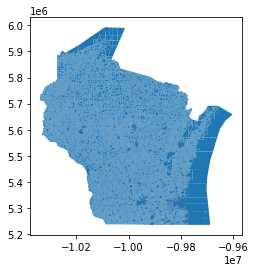

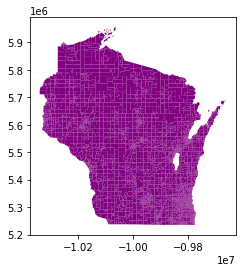

In [92]:
blk_joined.plot()
precincts.plot(color='purple')

### Prorate Demographic and Voting Population Data from the Block level to Precincts

In [93]:
proj = blk_joined.crs

This is sometimes necessary in order to get rid of topology errors

Ruth from MGGG recommended this - not sure exactly what it does but it works, "buffer the geometries with zero distance"


In [95]:
blk_joined["geometry"] = blk_joined.buffer(0)
precincts["geometry"] = precincts.buffer(0)

See MAUP library for details (linked in imports). In short, MAUP assign is mapping every geometry in the census block file to the precinct file. 


In [97]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

blk_joined = blk_joined.to_crs(proj)

pieces = maup.assign(blk_joined, precincts)

Sum the census block demo columns within the precincts and assign them to the precinct shapefile


In [98]:
precincts[variables] = blk_joined[variables].groupby(pieces).sum()

Confirm the total population of the precinct shapefile after prorating the census blocks to precincts


In [99]:
precincts.TOTPOP.sum()

5683569.0

**Assign congressional districts to precincts**

Because the MGGG file contains CDs, read in the shapefile and project it


In [100]:
cd = gp.read_file('./raw-from-source/Wisconsin_Congressional_Districts_2011-shp/Wisconsin_Congressional_Districts_2011.shp')

In [101]:
cd = cd.to_crs(proj)

Assign the CDs to the precinct as well using MAUP, save the assignments to a separate object


In [130]:
assignments = maup.assign(precincts, cd)

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -10256267.161800001 5888365.7695999965 at -10256267.161800001 5888365.7695999965


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x7fa878698100>

**Topology error in Congressional Districts shp due to ring self-intersection, attempt to run maup.resolve_overlaps to try to fix it**


Help on function resolve_overlaps in module maup.repair:

resolve_overlaps(geometries, relative_threshold=0.1)
    For any pair of overlapping geometries, assigns the overlapping area to the
    geometry that shares the most perimeter with the overlap. Returns the GeoSeries
    of geometries, which will have no overlaps.
    
    If the ratio of the overlap's area to either of the overlapping geometries'
    areas is greater than `relative_threshold`, then the overlap is ignored.
    The default `relative_threshold` is `0.1`. This default is chosen to include
    tiny overlaps that can be safely auto-fixed while preserving major overlaps
    that might indicate deeper issues and should be handled on a case-by-case
    basis. Set `relative_threshold=None` to resolve all overlaps.
    
**Also tried maup.close_gaps, same topology error**



In [ ]:
fix_topology = maup.resolve_overlaps(cd, relative_threshold=None)


See what it looks like. There are 8 CDs in WI, but these are numbered 0-7, need to bump them all up by 1 because of Python indexing and then confirm after that that looks right. 


In [ ]:
print(assignments.unique())


In [24]:
# There is no '0' district, need to add 1 to IDs
assignments = assignments + 1.0

In [25]:
# Assign the CDs to the precincts shapefile
precincts["CD_DIST"] = assignments

In [26]:
# Confirm what it looks like and that the CD assignment is correct by looking up some counties
precincts.head()

,locality,loc_prec,district,HD,Precinct,G18DHOR,G18DSEN,G18OHOR,G18OSEN,G18RHOR,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD_DIST
0,Norfolk,Norfolk Titustown,Congressional District 2,79,Titustown,666,680,0,12,87,...,5943,612,2763,2194,48,163,18,7,138,2.0
1,Norfolk,Norfolk Second Presbyterian,Congressional District 2,79,Second Presbyterian,1138,1165,0,43,620,...,6839,513,4043,1604,38,452,18,15,156,2.0
2,Norfolk,Norfolk Crossroads,Congressional District 2,100,Crossroads,894,893,0,48,657,...,3879,278,2577,816,14,112,2,2,78,2.0
3,Norfolk,Norfolk Northside,Congressional District 2,100,Northside,743,763,0,27,564,...,3032,195,2161,429,13,160,13,5,56,2.0
4,Norfolk,Norfolk Ballentine,Congressional District 3,89,Ballentine,1173,1154,0,23,0,...,3529,171,714,2543,14,20,2,2,63,3.0


**Assign house districts to blocks**

The following has the same process as above CD assignment. 

**_2012_**

In [131]:
state_house12 = gp.read_file('./raw-from-source/Wisconsin_Assembly_Districts_2012-shp/Wisconsin_Assembly_Districts_2012.shp')

In [132]:
state_house12["geometry"] = state_house12.buffer(0)

In [133]:
assignments = maup.assign(precincts, state_house12)

In [134]:
# There is no '0' district, need to add 1 to IDs
assignments += 1

precincts["HD_DIST11"] = assignments

**Matched districts correspond to those included in precinct data**

In [135]:
precincts[['CD_DIST', 'district']]

KeyError: "None of [Index(['CD_DIST', 'district'], dtype='object')] are in the [columns]"

In [36]:
## Save shapefile
# precincts.to_file("WI_PGP_replication-census.shp")

### Load PGP WI shapefile to compare results

In [121]:
final = gp.read_file('./raw-from-source/2018-2012_Election_Data_with_2011_Wards-shp/2018-2012_Election_Data_with_2011_Wards.shp')

In [122]:
precincts = precincts.rename(columns={"Precinct": "precinct"})

In [127]:
# Join your final version and the PGP final version
validate = pd.merge(precincts, final, on=['loc_prec'], how='left')

KeyError: 'loc_prec'

**Check population**

In [124]:
validate['pop_diff'] = validate.TOTPOP_x - validate.TOTPOP_y

NameError: name 'validate' is not defined

In [125]:
validate[validate.pop_diff.abs()<10].shape[0] / validate.shape[0]

NameError: name 'validate' is not defined

In [42]:
validate['bpop_diff'] = validate.NH_BLACK_x - validate.NH_BLACK_y

In [43]:
validate[validate.bpop_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check voting age population**

In [44]:
validate['bvap_diff'] = validate.BVAP_x - validate.BVAP_y

In [45]:
validate[validate.bvap_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check state house districts**

In [46]:
validate.HD_DIST12 = validate.HD_DIST12.astype(int)
validate.HDIST_12 = validate.HDIST_12.astype(int)
validate.HDIST_REM = validate.HDIST_REM.astype(int)

**All state House districts match MGGG's assigned state House districts**

**_2012_**

In [136]:
#number of districts that don't match MGGG's
validate[['HD_DIST12', 'HDIST_12']].assign(NE=validate.HDIST_11 != validate.HD_DIST11)['NE'].sum()

NameError: name 'validate' is not defined

In [137]:
validate[['HD_DIST12', 'HDIST_12']].head()

NameError: name 'validate' is not defined

**Check votes of 2016 Democratic US House candidate by congressional district**

In [51]:
precincts.groupby('CD_DIST')['G18DHOR'].sum()

CD_DIST
1.0     149331
2.0     139352
3.0     197954
4.0     188566
5.0     144769
6.0     113044
7.0     175172
8.0     248981
9.0      85903
10.0    200994
11.0    221464
Name: G18DHOR, dtype: int64

**Check votes of 2016 Democratic US House candidate by congressional district**

In [138]:
precincts.groupby('HD_DIST12')['G17DHOD'].sum().head(10)

KeyError: 'HD_DIST12'